In [35]:
from collections import defaultdict

import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from matplotlib import pyplot as plt
from sklearn.metrics import (f1_score, precision_score, recall_score,
                             accuracy_score, hamming_loss, jaccard_score,multilabel_confusion_matrix,ConfusionMatrixDisplay)
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logging.getLogger("mlflow").setLevel(logging.ERROR)


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device : {device}")

device : cuda


In [3]:
categories = ["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology", "Quantitative Finance"]

In [4]:
val_df = pd.read_csv("data/val_cleaned.csv")
total_samples = len(val_df)
categories_distribution = val_df[categories].sum()
categories_distribution

Computer Science        1719
Physics                 1203
Mathematics             1124
Statistics              1041
Quantitative Biology     117
Quantitative Finance      50
dtype: int64

In [17]:
def combine_labels(batch):
    label_lists = [batch[cat] for cat in categories]    
    numpy_array = np.array(label_lists)
    transpose = numpy_array.T
    labels = transpose.tolist()
    return {
        "labels": labels,
    }

In [24]:
from datasets import load_dataset, Sequence, Value

val_dataset = load_dataset("csv",data_files="data/val_cleaned.csv")["train"]
val_dataset = val_dataset.map(combine_labels, batched=True, batch_size=64)
new_features = val_dataset.features.copy()
new_features["labels"] = Sequence(Value("float32"))
val_dataset = val_dataset.cast(new_features)

In [19]:
def compute_metrics(preds, labels):
    logits = preds.predictions
    y_pred = (torch.sigmoid(torch.tensor(logits)) > 0.5).int().numpy()
    f1_weighted = f1_score(y_true=labels, y_pred=y_pred, average='weighted')
    f1_macro = f1_score(y_true=labels, y_pred=y_pred, average='macro')
    precision_weighted = precision_score(y_true=labels, y_pred=y_pred, average='weighted')
    precision_macro = precision_score(y_true=labels, y_pred=y_pred, average='macro')
    recall_weighted = recall_score(y_true=labels, y_pred=y_pred, average='weighted')
    recall_macro = recall_score(y_true=labels, y_pred=y_pred, average='macro')
    accuracy = accuracy_score(y_true=labels, y_pred=y_pred, normalize=True)
    h_loss = hamming_loss(labels, y_pred)
    jaccard_macro = jaccard_score(labels, y_pred, average='macro')
    
    return {
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "accuracy_subset": accuracy,
        "hamming_loss": h_loss,
        "jaccard_macro": jaccard_macro
    }

In [57]:
from transformers import AutoTokenizer


def get_output_from_trained_model(path, dataset=None):
    saved_tokenizer = AutoTokenizer.from_pretrained(f"{path}/tokenizer")
    if dataset is None:
        tokenized_dataset = val_dataset.map(
        lambda batch: saved_tokenizer(
            batch["text"], 
            padding="max_length", 
            truncation=True,
        max_length=512), batched=True, batch_size=64)
    else:
        tokenized_dataset = dataset.map(
        lambda batch: saved_tokenizer(
            batch["text"], 
            padding="max_length", 
            truncation=True,
        max_length=512), batched=True, batch_size=64)
    trained_model = AutoModelForSequenceClassification.from_pretrained(f"{path}/model")
    trained_model.eval()
    trained_model.to(device)
    eval_args = TrainingArguments(
        output_dir="./temp_inference",
        per_device_eval_batch_size=64,
    )
    trainer = Trainer(
        model=trained_model,
        args=eval_args,
    )
    output = trainer.predict(tokenized_dataset)
    return output

In [83]:
def analyse_trained_model(path, fine_tuned_thresholds=None, show_plots=True):
    output = get_output_from_trained_model(path)
    metrics = compute_metrics(output, labels = val_dataset["labels"])
    print(f"metrics ==== {metrics}")
    logits = output.predictions
    labels = output.label_ids
    if fine_tuned_thresholds is None:
        thresholds_tensor = torch.tensor([0.5,0.5,0.5,0.5,0.5,0.5], dtype=torch.float32)
    else:
        thresholds_tensor = torch.tensor(fine_tuned_thresholds, dtype=torch.float32)
    y_pred = (torch.sigmoid(torch.tensor(logits)) > thresholds_tensor).int().numpy()
    multi_label_cm = multilabel_confusion_matrix(labels, y_pred)
    if show_plots:
        for index, cm in enumerate(multi_label_cm):
            print(f"Confusion matrix for {categories[index]}")
            sum = np.sum(cm, axis=0)
            # print(sum)
            normalized = cm.astype('float') / sum
            # print(normalized)
            
            disp = ConfusionMatrixDisplay(confusion_matrix=normalized, display_labels=["Others", categories[index]])
    
            disp.plot()
            plt.show()
            print(f"{'=' * 100}")
        print(f"{'=' * 200}")
        for index, cm in enumerate(multi_label_cm):
            print(f"Confusion matrix for {categories[index]}")
            sum = np.sum(cm, axis=1)
            # print(sum)
            divisor = sum[:, np.newaxis]
            normalized = cm.astype('float') / divisor
            # print(normalized)
            disp = ConfusionMatrixDisplay(confusion_matrix=normalized, display_labels=["Others", categories[index]])
    
            disp.plot()
            plt.show()
            print(f"{'=' * 100}")
    class_f1 = f1_score(labels, y_pred, average=None)
    class_precision = precision_score(labels, y_pred, average=None)
    class_recall = recall_score(labels, y_pred, average=None)
    return class_precision, class_recall, class_f1

In [33]:
path = "./best_model/distill_bert_layer_5/fine_tune_1"
class_precision, class_recall, class_f1 = analyse_trained_model(path, show_plots=False)
for index in range(len(categories)):
    print(f"{categories[index]} = precision={class_precision[index]}, recall={class_recall[index]}, f1={class_f1[index]}")

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

metrics ==== {'f1_macro': 0.689090695527522, 'f1_weighted': 0.8023679617420596, 'precision_macro': 0.6018378939798222, 'precision_weighted': 0.7470074901865913, 'recall_macro': 0.8853245314684869, 'recall_weighted': 0.881423677198325, 'accuracy_subset': 0.5781956676981671, 'hamming_loss': 0.09803221455209077, 'jaccard_macro': 0.5513427259647515}
Computer Science = precision=0.8093447905477981, recall=0.8766724840023269, f1=0.8416643395699526
Physics = precision=0.837442218798151, recall=0.9035743973399833, f1=0.8692522990803678
Mathematics = precision=0.7474267616785432, recall=0.8398576512455516, f1=0.7909509844993716
Statistics = precision=0.6119402985074627, recall=0.9058597502401537, f1=0.7304415182029435
Quantitative Biology = precision=0.2789473684210526, recall=0.905982905982906, f1=0.42655935613682094
Quantitative Finance = precision=0.32592592592592595, recall=0.88, f1=0.4756756756756757


In [51]:
eval_dict = defaultdict(list)
# eval_dict["categories"] = categories
eval_dict["f1_layer_5"] = class_f1
eval_dict["precision_layer_5"] = class_precision
eval_dict["recall_layer_5"] = class_recall


In [40]:
path = "./best_model/distill_bert_layer_4/fine_tune_1"
class_precision_layer_4, class_recall_layer_4, class_f1_layer_4 = analyse_trained_model(path, show_plots=False)

# df["f1_layer_4"] = class_f1_layer_4
# df["precision_layer_4"] = class_precision_layer_4
# df["recall_layer_4"] = class_recall_layer_4
# df.head(6)

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

metrics ==== {'f1_macro': 0.7069514700552103, 'f1_weighted': 0.8134666434081821, 'precision_macro': 0.6219263076675166, 'precision_weighted': 0.7603150723284786, 'recall_macro': 0.8862536751897901, 'recall_weighted': 0.8858012942519985, 'accuracy_subset': 0.60080933111164, 'hamming_loss': 0.09041498056018409, 'jaccard_macro': 0.5704967493248955}


,categories,f1_layer_5,precision_layer_5,recall_layer_5,f1_layer_4,precision_layer_4,recall_layer_4
0,Computer Science,0.841664,0.809345,0.876672,0.845094,0.803038,0.891798
1,Physics,0.869252,0.837442,0.903574,0.873183,0.849175,0.898587
2,Mathematics,0.790951,0.747427,0.839858,0.793597,0.753600,0.838078
3,Statistics,0.730442,0.611940,0.905860,0.769355,0.665498,0.911623
4,Quantitative Biology,0.426559,0.278947,0.905983,0.445860,0.296610,0.897436
5,Quantitative Finance,0.475676,0.325926,0.880000,0.514620,0.363636,0.880000


In [52]:

eval_dict["f1_layer_4"] = class_f1_layer_4
eval_dict["precision_layer_4"] = class_precision_layer_4
eval_dict["recall_layer_4"] = class_recall_layer_4
df = pd.DataFrame.from_dict(eval_dict, orient="index", columns=categories)
df.head(10)

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
f1_layer_5,0.841664,0.869252,0.790951,0.730442,0.426559,0.475676
precision_layer_5,0.809345,0.837442,0.747427,0.611940,0.278947,0.325926
recall_layer_5,0.876672,0.903574,0.839858,0.905860,0.905983,0.880000
f1_layer_4,0.845094,0.873183,0.793597,0.769355,0.445860,0.514620
precision_layer_4,0.803038,0.849175,0.753600,0.665498,0.296610,0.363636
recall_layer_4,0.891798,0.898587,0.838078,0.911623,0.897436,0.880000


Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

metrics ==== {'f1_macro': 0.7433739000350298, 'f1_weighted': 0.823668714519497, 'precision_macro': 0.6899093527213531, 'precision_weighted': 0.7996869368802847, 'recall_macro': 0.8270751410136622, 'recall_weighted': 0.853254663113818, 'accuracy_subset': 0.651511544870269, 'hamming_loss': 0.07787828294850432, 'jaccard_macro': 0.6064959915580606}
Confusion matrix for Computer Science


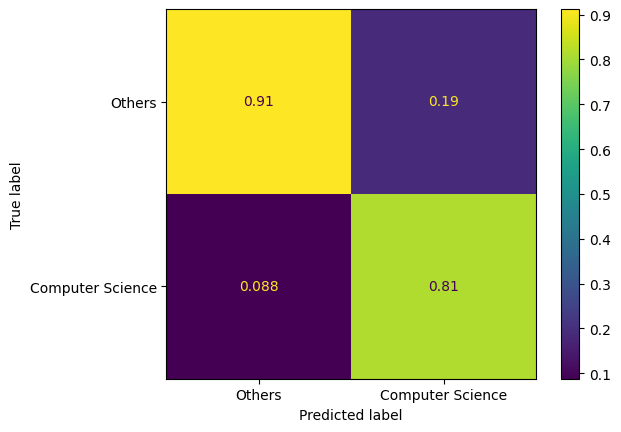

Confusion matrix for Physics


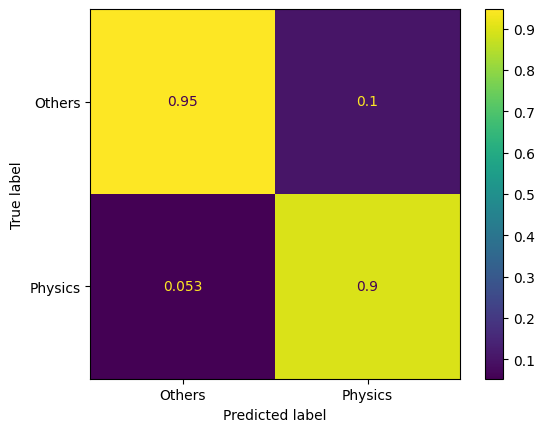

Confusion matrix for Mathematics


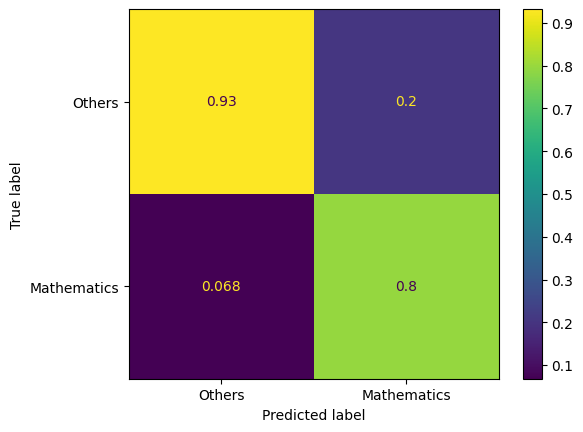

Confusion matrix for Statistics


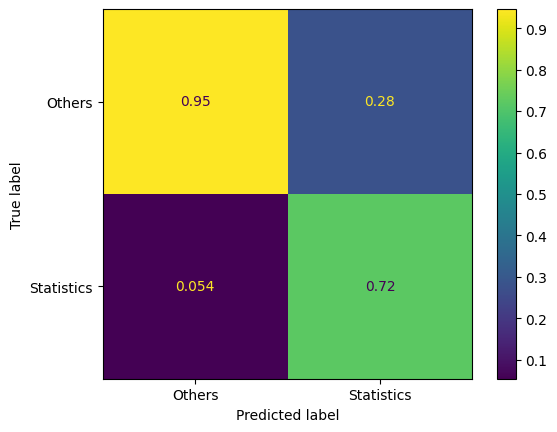

Confusion matrix for Quantitative Biology


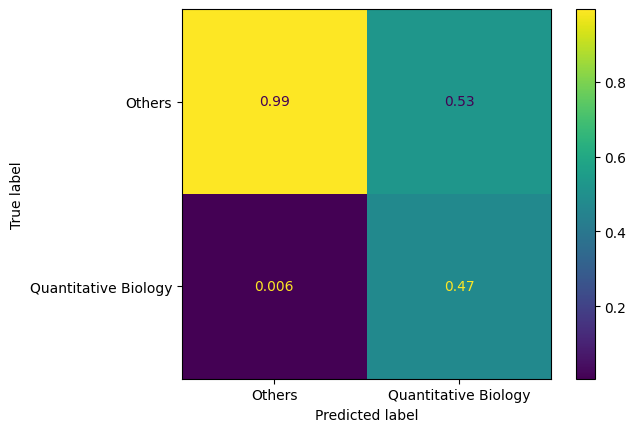

Confusion matrix for Quantitative Finance


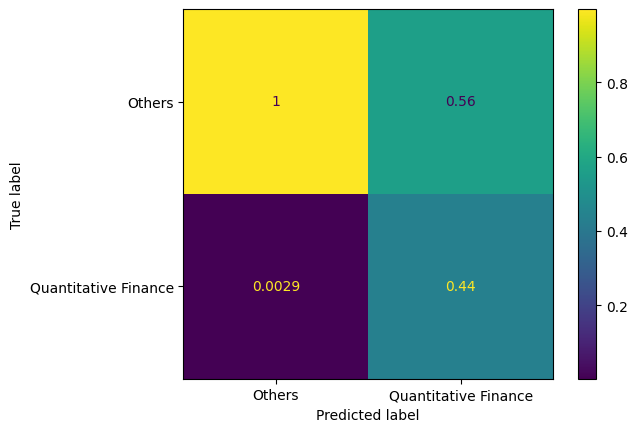

Confusion matrix for Computer Science


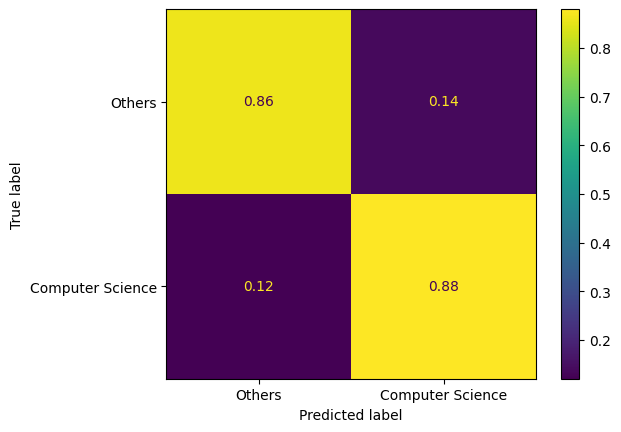

Confusion matrix for Physics


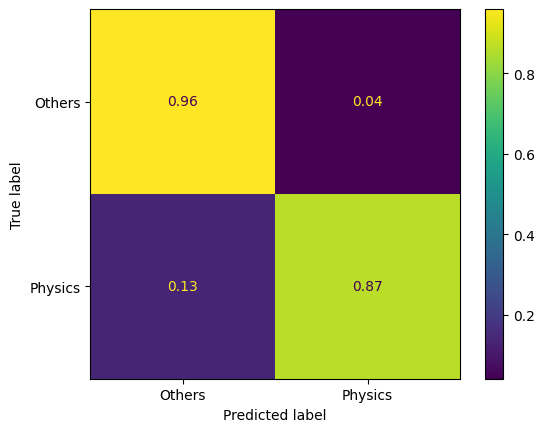

Confusion matrix for Mathematics


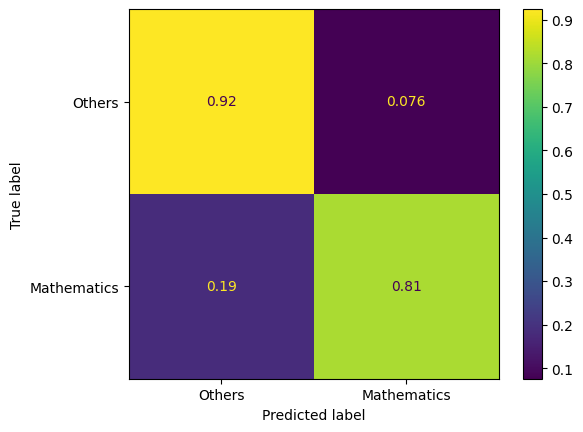

Confusion matrix for Statistics


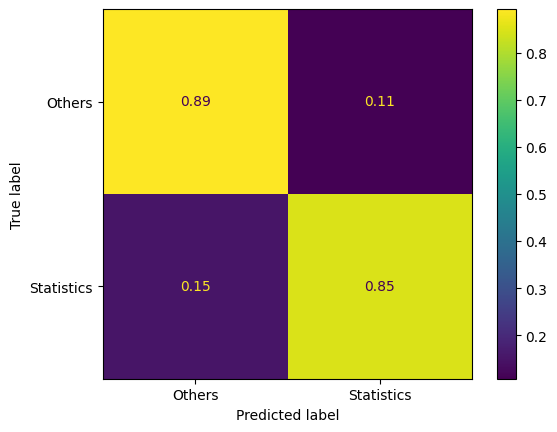

Confusion matrix for Quantitative Biology


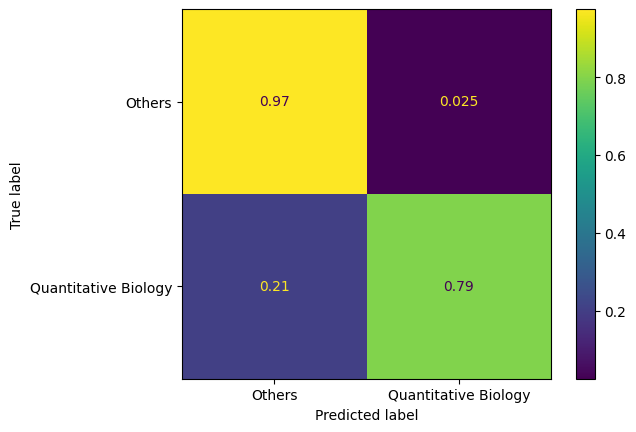

Confusion matrix for Quantitative Finance


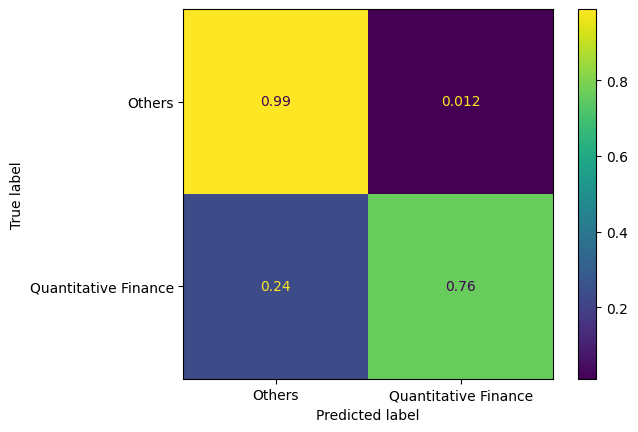

In [54]:
path = "./best_model/distill_bert_layer_5/fine_tune_pos_smoothed"
class_precision_pos_smoothed, class_recall_pos_smoothed, class_f1_pos_smoothed = analyse_trained_model(path, show_plots=True)

In [53]:
eval_dict["f1_layer_pos_smoothed"] = class_f1_pos_smoothed
eval_dict["precision_pos_smoothed"] = class_precision_pos_smoothed
eval_dict["recall_pos_smoothed"] = class_recall_pos_smoothed
df = pd.DataFrame.from_dict(eval_dict, orient="index", columns=categories)
df.head(10)

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
f1_layer_5,0.841664,0.869252,0.790951,0.730442,0.426559,0.475676
precision_layer_5,0.809345,0.837442,0.747427,0.611940,0.278947,0.325926
recall_layer_5,0.876672,0.903574,0.839858,0.905860,0.905983,0.880000
f1_layer_4,0.845094,0.873183,0.793597,0.769355,0.445860,0.514620
precision_layer_4,0.803038,0.849175,0.753600,0.665498,0.296610,0.363636
recall_layer_4,0.891798,0.898587,0.838078,0.911623,0.897436,0.880000
f1_layer_pos_smoothed,0.846197,0.880811,0.805629,0.778612,0.594249,0.554745
precision_pos_smoothed,0.814755,0.895959,0.796522,0.720949,0.474490,0.436782
recall_pos_smoothed,0.880163,0.866168,0.814947,0.846302,0.794872,0.760000


In [56]:
df.to_csv("data/eval_result.csv", index=False)

In [58]:
train_dataset = load_dataset("csv",data_files="data/train_cleaned.csv")["train"]
train_dataset = train_dataset.map(combine_labels, batched=True, batch_size=64)
new_features = train_dataset.features.copy()
new_features["labels"] = Sequence(Value("float32"))
train_dataset = train_dataset.cast(new_features)

In [76]:
def find_best_thresholds(labels, logits):
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    
    best_thresholds = []
    for i in range(len(categories)):
        best_f1 = 0
        best_thresh = 0.5
        
        # Test thresholds from 0.1 to 0.9
        for thresh in np.arange(0.1, 0.9, 0.01):
            temp_preds = (probs[:, i] > thresh).astype(int)
            current_f1 = f1_score(labels[:, i], temp_preds)
            
            if current_f1 > best_f1:
                best_f1 = current_f1
                best_thresh = thresh
        
        best_thresholds.append(round(best_thresh,2))
        print(f"Label {i} Best Threshold: {best_thresh:.2f} | F1: {best_f1:.4f}")
    
    return best_thresholds

In [86]:
path = "./best_model/distill_bert_layer_5/fine_tune_pos_smoothed"
train_output = get_output_from_trained_model(path, dataset=train_dataset)


Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

In [87]:
train_labels = np.array(train_dataset["labels"])
train_logits = train_output.predictions
fine_tuned_thresholds = find_best_thresholds(train_labels, train_logits)

Label 0 Best Threshold: 0.44 | F1: 0.8566
Label 1 Best Threshold: 0.50 | F1: 0.8938
Label 2 Best Threshold: 0.58 | F1: 0.8269
Label 3 Best Threshold: 0.51 | F1: 0.7777
Label 4 Best Threshold: 0.77 | F1: 0.6193
Label 5 Best Threshold: 0.81 | F1: 0.7341


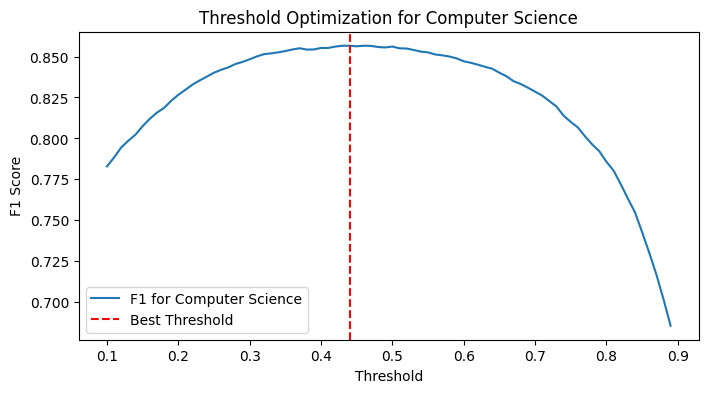

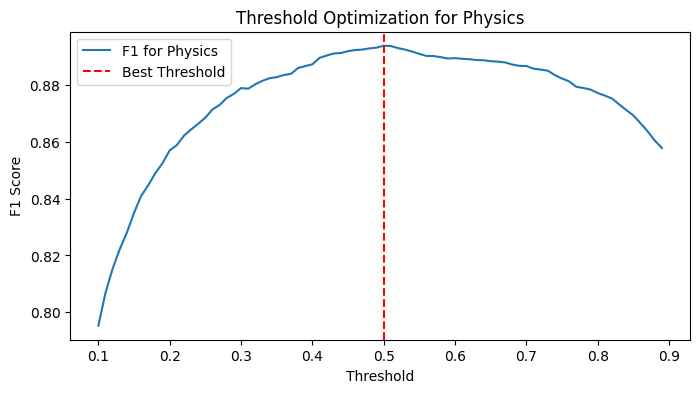

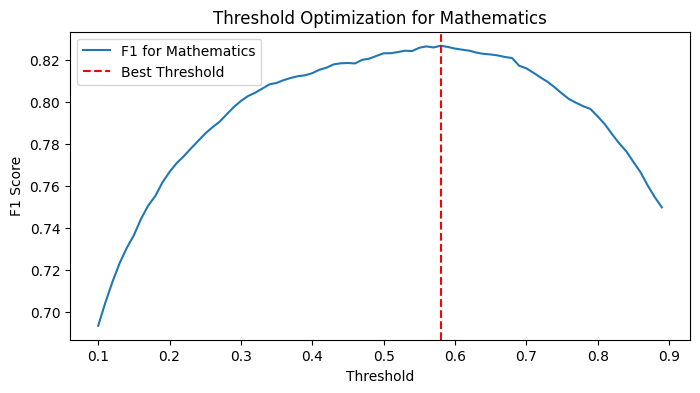

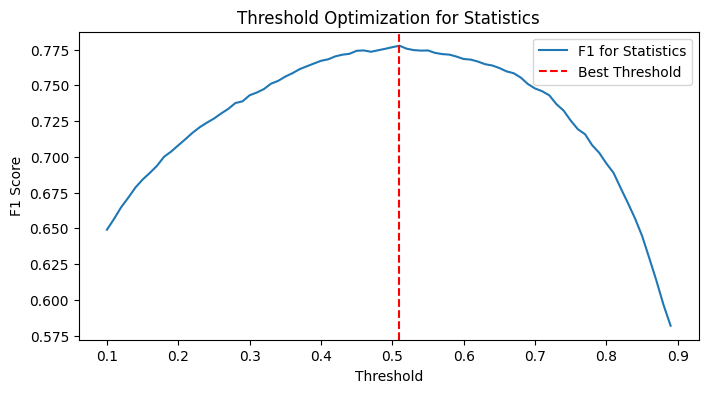

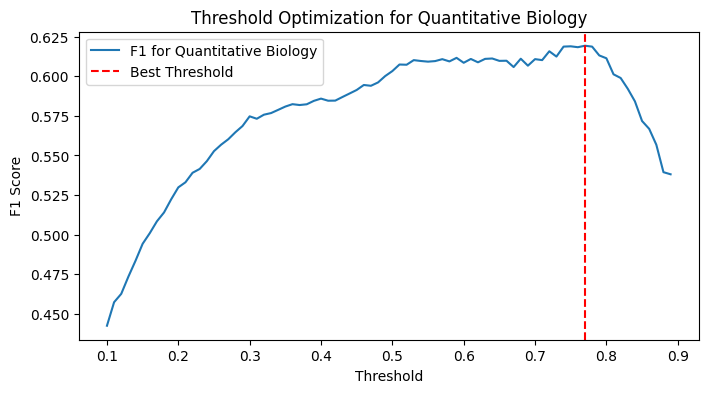

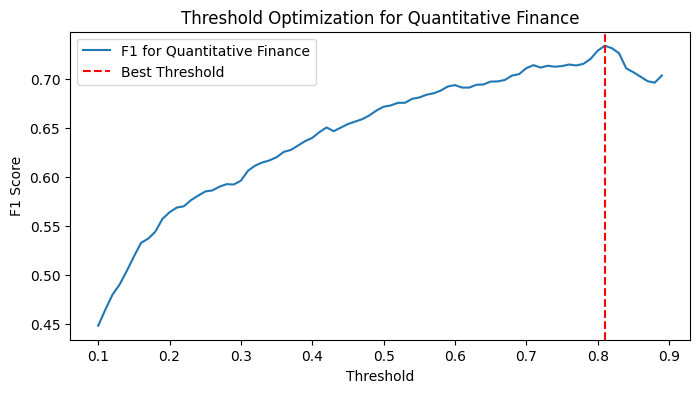

In [89]:
import matplotlib.pyplot as plt
def plot_f1_vs_threshold(labels, probs, class_index, class_name):
    thresholds = np.arange(0.1, 0.9, 0.01)
    f1_scores = []
    for t in thresholds:
        true_labels = labels[:, class_index]
        temp_preds = (probs[:, class_index] > t).astype(int)
        score = f1_score(true_labels, temp_preds)
        f1_scores.append(score)
    
    plt.figure(figsize=(8, 4))
    plt.plot(thresholds, f1_scores, label=f"F1 for {class_name}")
    plt.axvline(thresholds[np.argmax(f1_scores)], color='red', linestyle='--', label='Best Threshold')
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.title(f"Threshold Optimization for {class_name}")
    plt.legend()
    plt.show()

for i in range(len(categories)):
    probs = torch.sigmoid(torch.tensor(train_logits)).numpy()
    plot_f1_vs_threshold(train_labels, probs, i, categories[i])

Map:   0%|          | 0/4201 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

metrics ==== {'f1_macro': 0.7433739000350298, 'f1_weighted': 0.823668714519497, 'precision_macro': 0.6899093527213531, 'precision_weighted': 0.7996869368802847, 'recall_macro': 0.8270751410136622, 'recall_weighted': 0.853254663113818, 'accuracy_subset': 0.651511544870269, 'hamming_loss': 0.07787828294850432, 'jaccard_macro': 0.6064959915580606}
Confusion matrix for Computer Science


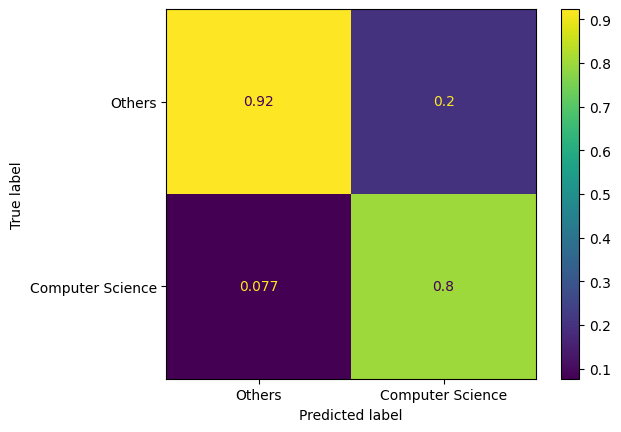

Confusion matrix for Physics


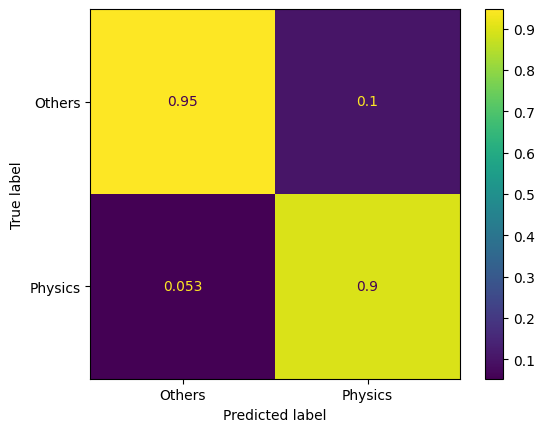

Confusion matrix for Mathematics


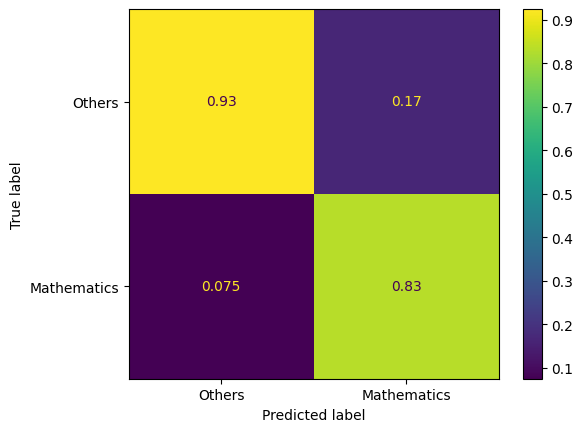

Confusion matrix for Statistics


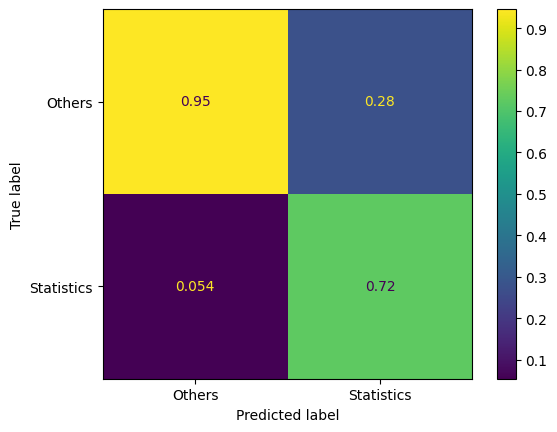

Confusion matrix for Quantitative Biology


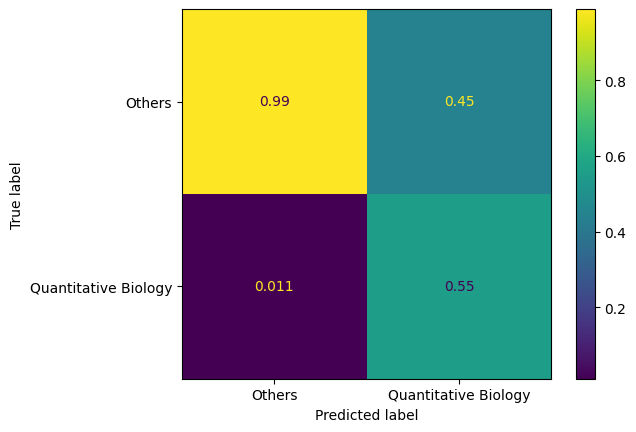

Confusion matrix for Quantitative Finance


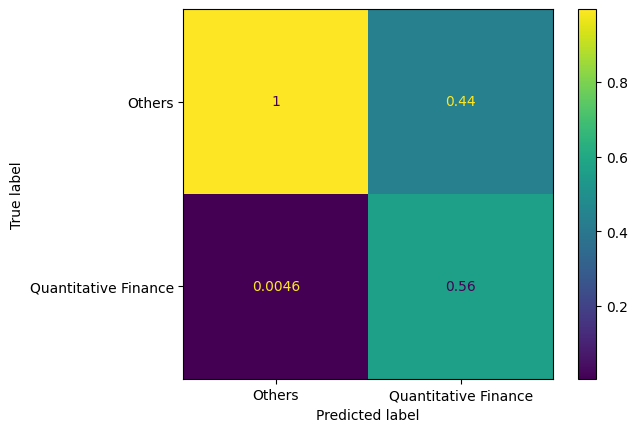

Confusion matrix for Computer Science


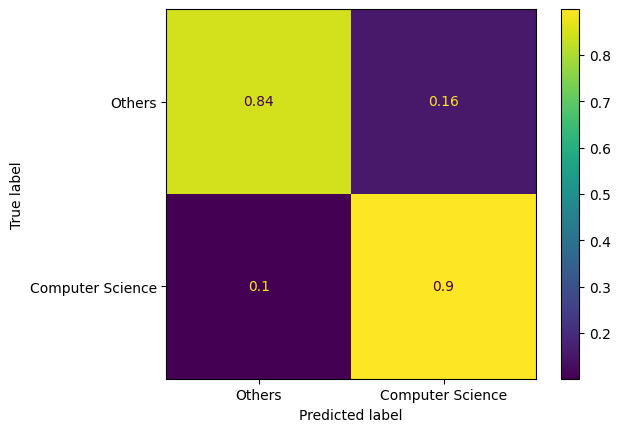

Confusion matrix for Physics


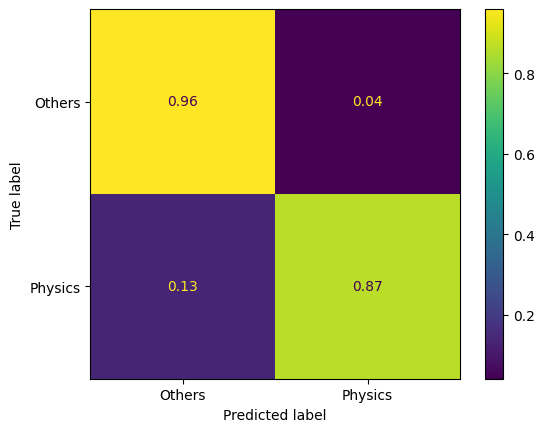

Confusion matrix for Mathematics


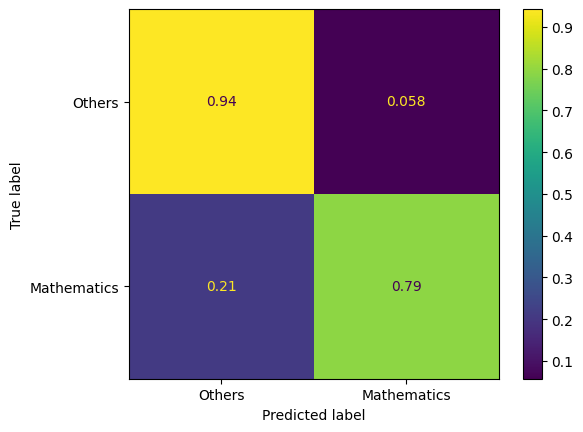

Confusion matrix for Statistics


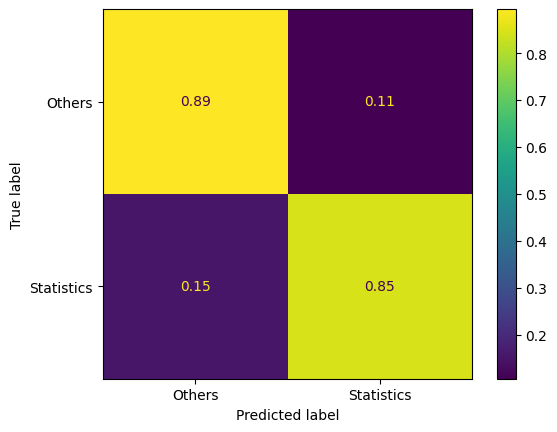

Confusion matrix for Quantitative Biology


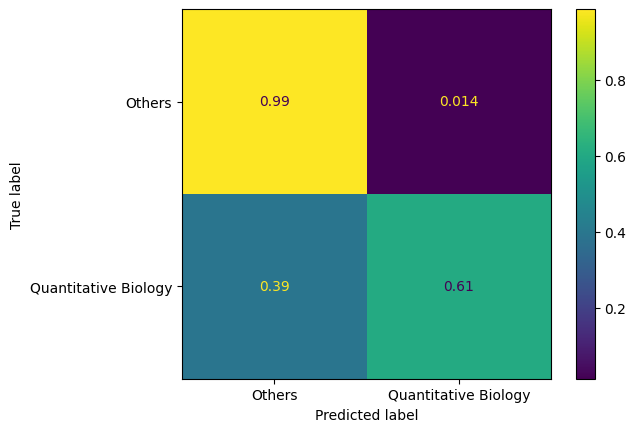

Confusion matrix for Quantitative Finance


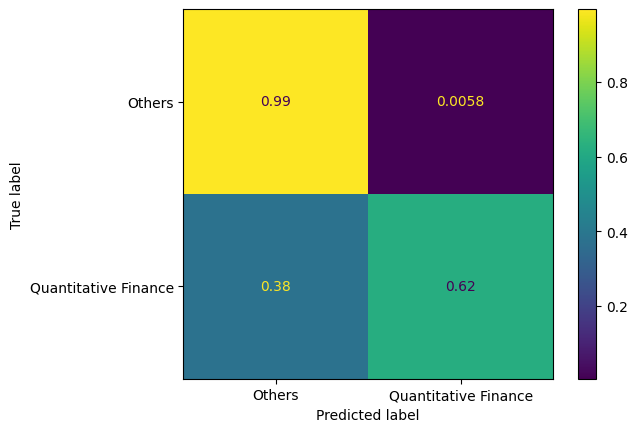

In [82]:
path = "./best_model/distill_bert_layer_5/fine_tune_pos_smoothed"
class_precision_pos_smoothed, class_recall_pos_smoothed, class_f1_pos_smoothed = analyse_trained_model(path, fine_tuned_thresholds)


In [91]:
fine_tune_dict = defaultdict(float)
for index in range(len(categories)):
    fine_tune_dict[categories[index]] = fine_tuned_thresholds[index]
category_df = pd.DataFrame.from_dict(fine_tune_dict, orient="index", columns=["Threshold"])
category_df

,Threshold
Computer Science,0.44
Physics,0.50
Mathematics,0.58
Statistics,0.51
Quantitative Biology,0.77
Quantitative Finance,0.81


In [93]:
category_df.to_csv("best_model/distill_bert_layer_5/fine_tune_pos_smoothed/fine_tune_threshold.csv", index=False)